# Pretrained model from RadImageNet

In [1]:
import tensorflow as tf
from tensorflow import keras

import SimpleITK as sitk
import numpy as np
import pandas as pd
import json

from scipy import ndimage
import matplotlib.pyplot as plt

from sklearn.model_selection  import train_test_split

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def read_nifti_file(file_path):
    """Read and load volume"""
    # Read file
    img = sitk.ReadImage(file_path)
    # 轉為 NumPy 陣列
    img_arr = sitk.GetArrayFromImage(img)

    return img_arr

In [5]:
#  input mask
# data_dir = 'C:\\Users\\Gina\\Lab\\kidney\\nnUNet-1\\Result'
data_dir = 'C:\\Users\\Gina\\Lab\\kidney\\nnUNet-1\\DataSet\\nnUnet_raw\\nnUNet_raw_data\\Task135_KiTS2021\\imagesTr'
mask_dir = 'C:\\Users\\Gina\\Lab\\kidney\\nnUNet-1\\Result'

data_path = []
mask_path = []

# append the mask files
for file in os.listdir(mask_dir):
    if "nii.gz" in file:
        mask_path.append(os.path.join(mask_dir, file))

# append the original image files
for file in os.listdir(data_dir):
    if "nii.gz" in file:
        data_path.append(os.path.join(data_dir, file))

In [5]:
def find_max_tumors(tumor_region):
    # There might be multiple tumors
    tumors = []
    tumors.append([(tumor_region[0][0], tumor_region[1][0], tumor_region[2][0])])
    tumor_idx = 1

    for i in range(1, len(tumor_region[0])):
        # (x, y, z) if x axis more than 10. -> thought to be another tumors
        # print('x, y, z:', tumor_region[0][i], tumors[tumor_idx - 1][-1][0], ',', tumor_region[1][i], tumors[tumor_idx - 1][-1][1], ',', tumor_region[2][i], tumors[tumor_idx - 1][-1][2])
        
        x_dis = abs(tumor_region[0][i] - tumors[tumor_idx - 1][-1][0])
        # y_dis = abs(tumor_region[1][i] - tumors[tumor_idx - 1][-1][1])
        # z_dis = abs(tumor_region[2][i] - tumors[tumor_idx - 1][-1][2])
        # print(x_dis, y_dis, z_dis)
        if x_dis >= 10:
            tumors.append([(tumor_region[0][i], tumor_region[1][i], tumor_region[2][i])])
            tumor_idx += 1
        else:
            tumors[tumor_idx - 1].append((tumor_region[0][i], tumor_region[1][i], tumor_region[2][i]))

    print('num of tumors:', len(tumors))
    # sorted the tumors
    sorted(tumors, key=lambda x: len(x))

    return tumors[-1]

def get_bounding_box(img, mask, tumor_only=False):
    tumor_region = np.where(mask == 2)

    # There is no tumors in the img
    if len(tumor_region[0]) == 0:
        return (666, 666, 666), (0, 0, 0)

    tumors = find_max_tumors(tumor_region)

    tumor_x = [ _tumor[0] for _tumor in tumors ]
    tumor_y = [ _tumor[1] for _tumor in tumors ]
    tumor_z = [ _tumor[2] for _tumor in tumors ]

    l_width = max(min(tumor_x) - 5, 0)
    l_height = max(min(tumor_y) - 5, 0)
    l_depth = max(min(tumor_z) - 5, 0)

    r_width = min(max(tumor_x) + 5, mask.shape[0])
    r_height = min(max(tumor_y) + 5, mask.shape[1])
    r_depth = min(max(tumor_z) + 5, mask.shape[2])

    # print('(before) img shape:', img.shape)
    # print('(before) mask shape:', mask.shape)
    # print('(l_width, l_height, l_depth):', f'{(l_width, l_height, l_depth)}', '(r_width, r_height, r_depth):', f'{(r_width, r_height, r_depth)}')
    # turn the kidney part to black
    img = img[l_width: r_width, l_height: r_height, l_depth: r_depth]
    # print('img shape:', img.shape)

    if tumor_only == True:
        box = np.full((r_width - l_width, r_height - l_height, r_depth - l_depth), -1024)
        # print('box shape:', box.shape)
        for _tumor in tumors:
            x = _tumor[0] - l_width
            y = _tumor[1] - l_height
            z = _tumor[2] - l_depth
            box[x][y][z] = img[x][y][z]
        return box

    # (l_width, l_height, l_depth), (r_width, r_height, r_depth)
    return img

def get_tumor_region(file_path, mask_path, tumor_only=False):
    img = read_nifti_file(file_path)
    mask = read_nifti_file(mask_path)

    return get_bounding_box(img, mask, tumor_only)

In [58]:
read_nifti_file(mask_path[0])

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [6]:
tumor_region = np.where(read_nifti_file(mask_path[1]) == 2)
tmp = find_max_tumors(tumor_region)

num of tumors: 1


num of tumors: 1


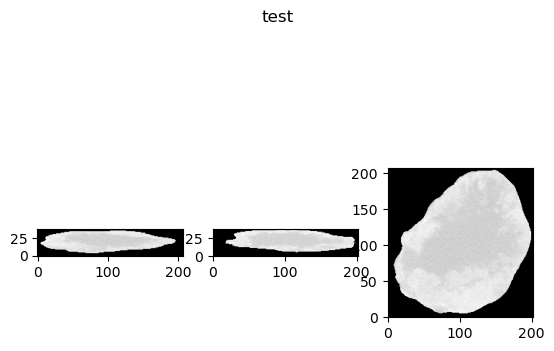

In [9]:
img = get_tumor_region(data_path[30], mask_path[30], True)
show_mid_slice(img, "test")

In [60]:
idx = 0
for img_path, mask in zip(data_path, mask_path):
    # try:
    img = get_tumor_region(img_path, mask, True)
    # show_mid_slice(img, 'first image')
    # print(img.shape)
    np.save(f"ground_truth_img/case_{idx}.npy", img)
    idx += 1
    del img
    # except:
    #     print(img_path)

num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 2
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors: 1
num of tumors:

In [24]:
ct_data = []
for idx in range(300):
    ct_data.append(np.load(f"ground_truth/case_{idx}.npy")) # cropped_black

In [7]:
def show_mid_slice(img_numpy, title='img'):
   """
   Accepts an 3D numpy array and shows median slices in all three planes
   """
   assert img_numpy.ndim == 3
   n_i, n_j, n_k = img_numpy.shape

   # sagittal (left image)
   center_i1 = int((n_i - 1) / 2)
   # coronal (center image)
   center_j1 = int((n_j - 1) / 2)
   # axial slice (right image)
   center_k1 = int((n_k - 1) / 2)

   show_slices([img_numpy[center_i1, :, :],
               img_numpy[:, center_j1, :],
               img_numpy[:, :, center_k1]])
   plt.suptitle(title)
   plt.savefig('cropped_tumor_img/' + title +'.png')

def show_slices(slices):
   """
   Function to display a row of image slices
   Input is a list of numpy 2D image slices
   """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")


In [8]:
def plot_3d(image, threshold=0, to_show=False, title='img'):
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    if to_show is True:
        plt.savefig('ground_truth_3d_img/'+ title + '.png')
        plt.close()
    else:
        plt.show()

In [68]:
plot_3d(ct_data[0], 0, True, '1')

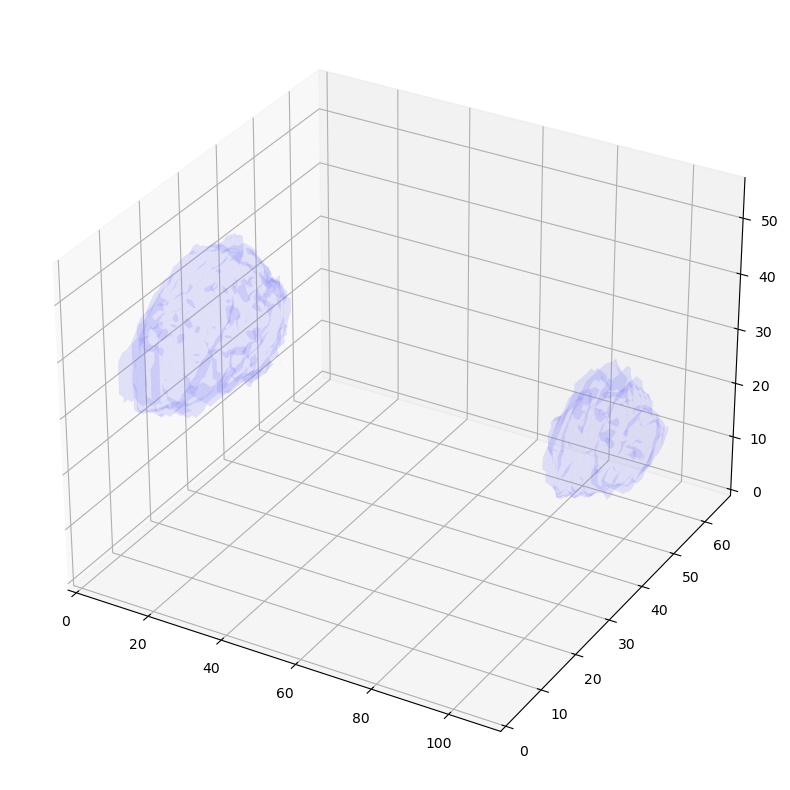

In [63]:
plot_3d(ct_data[1])

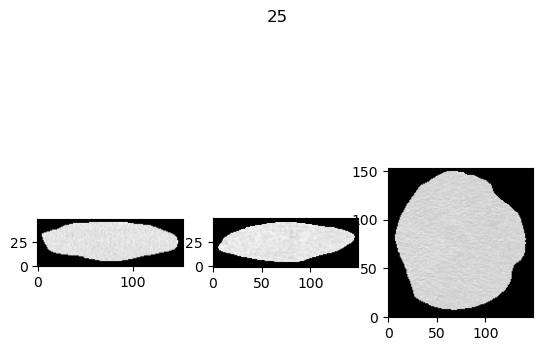

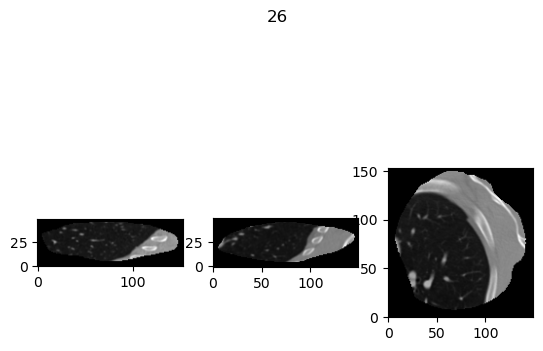

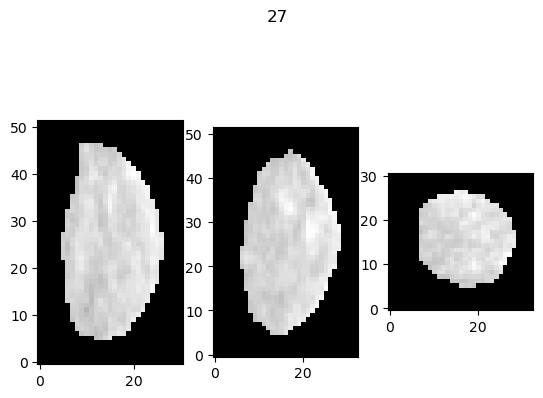

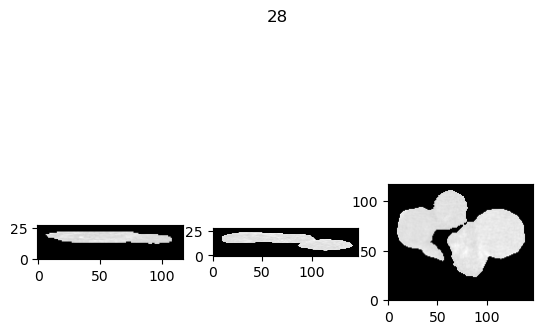

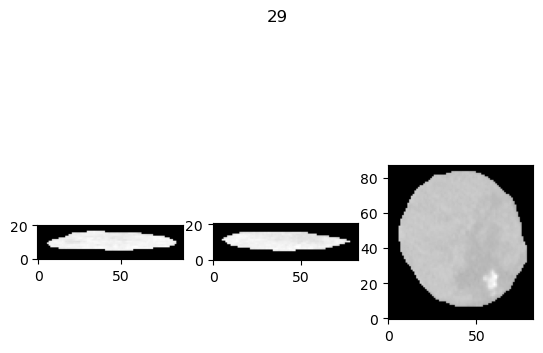

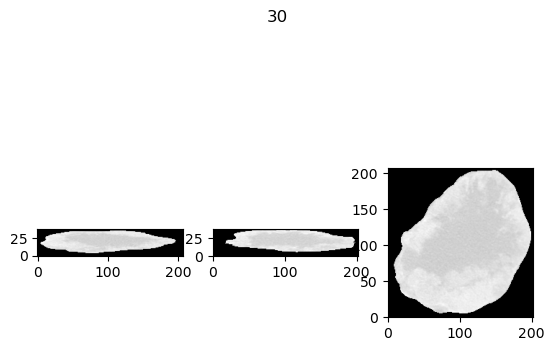

In [136]:
for idx in range(25, 31):
    show_mid_slice(ct_data[idx], str(idx))

In [ ]:
for idx in range(300):
    try:
        show_mid_slice(ct_data[idx], f'{idx}')
    except:
        print('error image with idx:', idx)

In [69]:
for idx in range(64, 300):
    try:
        plot_3d(ct_data[idx], 0, True, str(idx))
    except:
        print('error image with idx:', idx)

In [25]:
max_x = 0
max_y = 0
max_z = 0

avg_x = 0
avg_y = 0
avg_z = 0

drop_idx_img = []

for idx in range(len(ct_data)):
    if len(ct_data[idx].shape) != 3 or ct_data[idx].shape[2] == 0:
        print(idx, 'has error shape: ', ct_data[idx].shape)
        drop_idx_img.append(idx)
        continue
    max_x = max(ct_data[idx].shape[0], max_x)
    max_y = max(ct_data[idx].shape[1], max_y)
    max_z = max(ct_data[idx].shape[2], max_z)

    avg_x += ct_data[idx].shape[0]
    avg_y += ct_data[idx].shape[1]
    avg_z += ct_data[idx].shape[2]

print(f"x: {max_x}, y: {max_y}, z: {max_z} in maximum.")
print(f"x: {avg_x / len(ct_data)}, y: {avg_y / len(ct_data)}, z: {avg_z / len(ct_data)} in average.")

x: 205, y: 251, z: 278 in maximum.
x: 72.08333333333333, y: 73.38, z: 36.82333333333333 in average.


In [10]:
def resize_volume(img, desired_depth=64, desired_width=128, desired_height=128):
    """Resize across z-axis"""
    
    # Get current depth
    current_width = img.shape[0]
    current_height = img.shape[1]
    current_depth = img.shape[-1]
    
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height

    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [11]:
with open('C:\\Users\\Gina\\Lab\\kidney\\kits21\\kits21\\data\\kits.json') as f:
    data = json.load(f)
    data = pd.DataFrame(data)

In [27]:
# Benign data
benign_idx = data.loc[data['malignant'] == False].index
data_info = []

for idx in benign_idx:
    row = {}
    row['image_idx'] = idx
    row['x'] = ct_data[idx].shape[0]
    row['y'] = ct_data[idx].shape[1]
    row['z'] = ct_data[idx].shape[2]
    row['volume'] = len(np.where(ct_data[idx] != -1024)[0])
    row['malignant'] = False
    data_info.append(row)

benign_info = pd.DataFrame(data_info)
benign_info.to_csv('output/benign_shape.csv')

# Malignant data
mal_idx = data.loc[data['malignant'] == True].index
for idx in mal_idx:
    row = {}
    row['image_idx'] = idx
    row['x'] = ct_data[idx].shape[0]
    row['y'] = ct_data[idx].shape[1]
    if len(ct_data[idx].shape) == 3:
        row['z'] = ct_data[idx].shape[2]
    else:
        row['z'] = 0
    row['volume'] = len(np.where(ct_data[idx] != -1024)[0])
    row['malignant'] = True
    data_info.append(row)

# Filter out Malignant data
data_info = pd.DataFrame(data_info)
malignant_info = data_info[data_info['malignant']  == True]
malignant_info.to_csv('output/malignant_shape.csv')

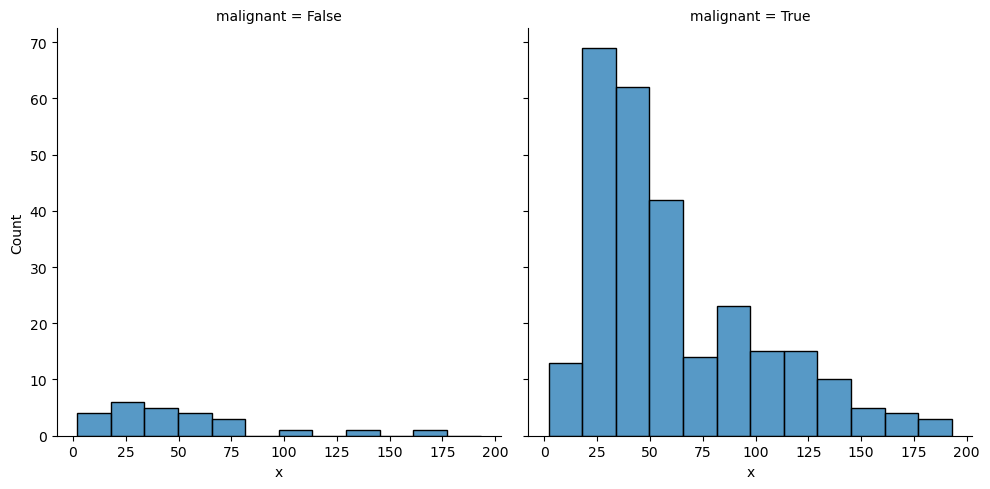

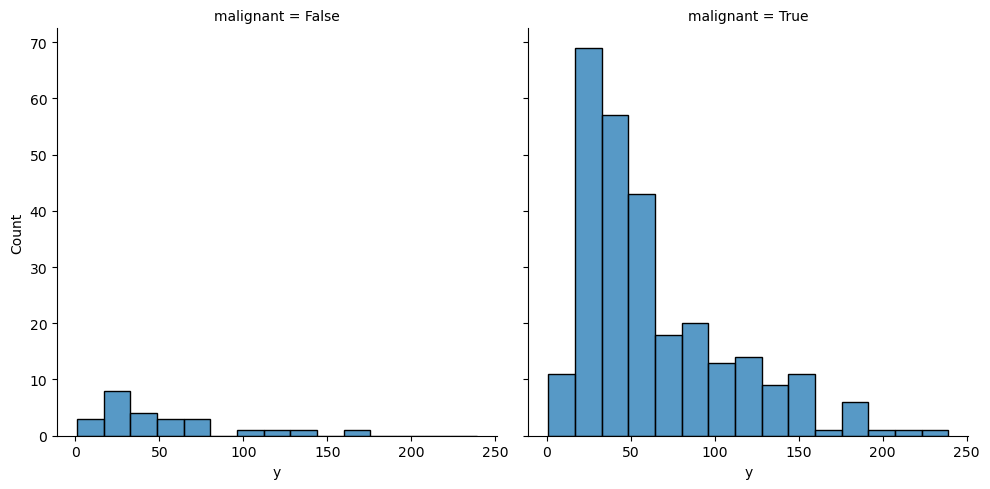

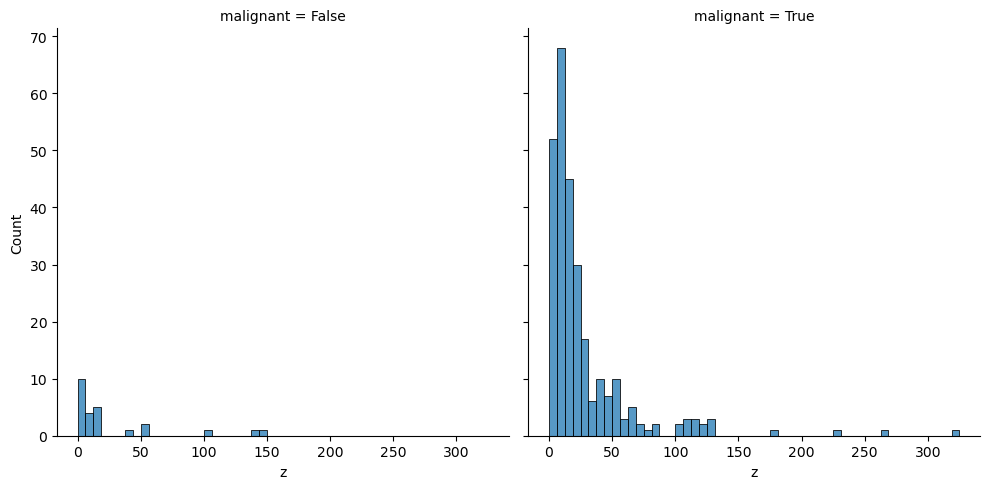

In [70]:
import seaborn as sns

%matplotlib inline
sns.displot(data_info, x="x", col="malignant")
sns.displot(data_info, x="y", col="malignant")
sns.displot(data_info, x="z", col="malignant")

In [26]:
ct_data = np.delete(ct_data, drop_idx_img)
ct_data = np.array(list(map(resize_volume, ct_data)))

c:\Users\Gina\anaconda3\envs\tf-gpu\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [13]:
ct_data.shape

(297, 128, 128, 64)

In [14]:
label_grade = data[['tumor_isup_grade', 'pathology_t_stage', 'malignant']]
label_grade = label_grade.rename(columns={'tumor_isup_grade': 'grade', 'pathology_t_stage': 'stage'})

label_grade.loc[ label_grade['grade'] <= 2, ['grade']] = 0
label_grade.loc[ label_grade['grade'] > 2, ['grade']] = 1

# drop useless tumor image
label_grade = label_grade.drop(index=drop_idx_img)

# reindex the label
label_grade.index = range(len(label_grade))
drop_index = label_grade[label_grade['grade'].isna()].index.tolist()
# print(drop_index)

# drop for missing grade
label_grade = label_grade.drop(index=drop_index)
label_grade.index = range(len(label_grade))
ct_data = np.delete(ct_data, drop_index, axis=0)

print('ct shape:', ct_data.shape, ', label shape:', label_grade.shape)

ct shape: (241, 128, 128, 64) , label shape: (241, 3)


In [27]:
label_benign = data[['tumor_isup_grade', 'pathology_t_stage', 'malignant']]
label_benign = label_benign.rename(columns={'tumor_isup_grade': 'grade', 'pathology_t_stage': 'stage'})

# drop useless tumor image
label_benign = label_benign.drop(index=drop_idx_img)

# # reindex the label
label_benign.index = range(len(label_benign))

drop_index = label_benign[label_benign['malignant'].isna()].index.tolist()
# print(drop_index)

# drop for missing grade
label_benign = label_benign.drop(index=drop_index)
label_benign.index = range(len(label_benign))
ct_benign_data = np.delete(ct_data, drop_index, axis=0)

print('ct shape:', ct_benign_data.shape, ', label shape:', label_benign.shape)

ct shape: (300, 128, 128, 64) , label shape: (300, 3)


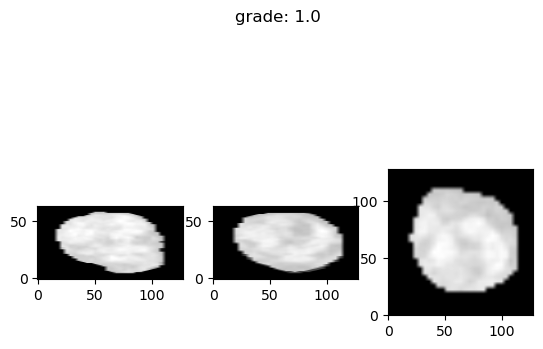

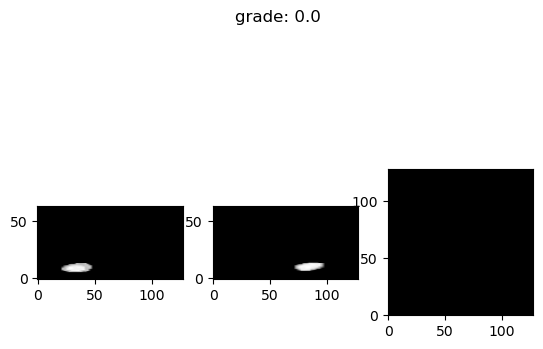

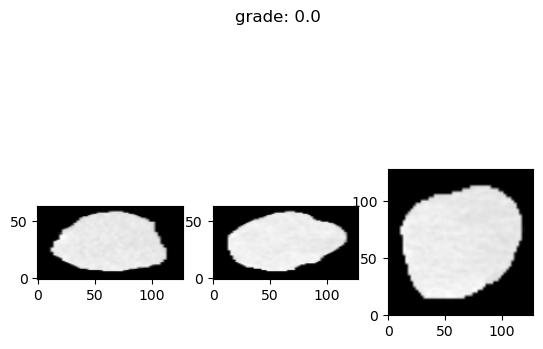

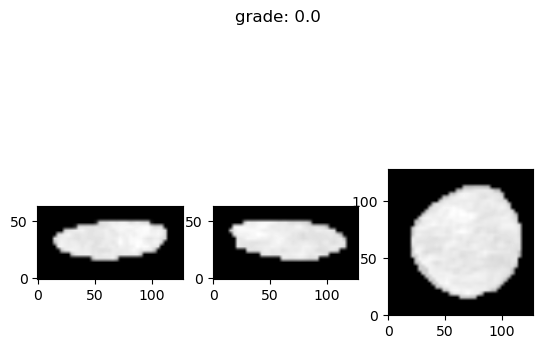

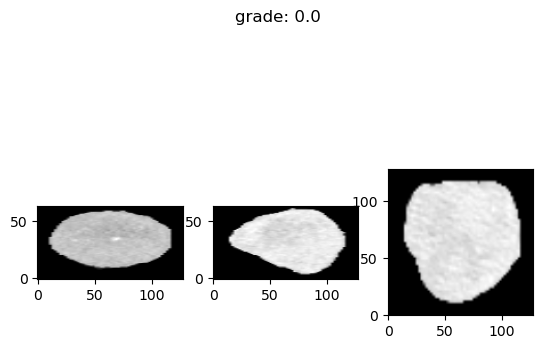

In [16]:
for idx in range(5):
    show_mid_slice(ct_data[idx], f"grade: {list(label_grade['grade'])[idx]}")

In [17]:
print('low grade:', len(label_grade[label_grade['grade'] == 0]))
print('high grade:', len(label_grade[label_grade['grade'] == 1]))

low grade: 149
high grade: 92


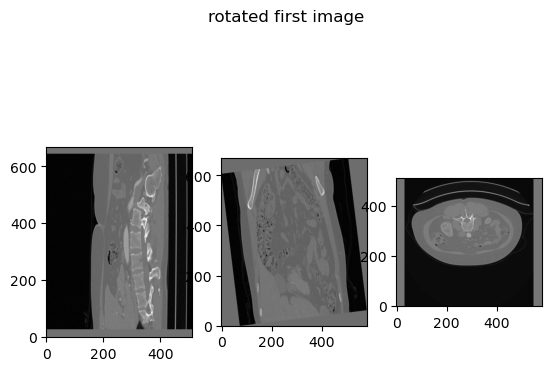

In [47]:
def random_rotate3D(img_numpy, min_angle, max_angle):
   """
   Returns a random rotated array in the same shape
   :param img_numpy: 3D numpy array
   :param min_angle: in degrees
   :param max_angle: in degrees
   """
   assert img_numpy.ndim == 3, "provide a 3d numpy array"
   assert min_angle < max_angle, "min should be less than max val"
   assert min_angle > -360 or max_angle < 360


   all_axes = [(1, 0), (1, 2), (0, 2)]
   angle = np.random.randint(low=min_angle, high=max_angle+1)
   axes_random_id = np.random.randint(low=0, high=len(all_axes))
   axes = all_axes[axes_random_id]

   return ndimage.rotate(img_numpy, angle, axes=axes)

show_mid_slice(random_rotate3D(mask[0], -10, 10), 'rotated first image')

In [15]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = keras.layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.GlobalAveragePooling3D()(x)
    x = keras.layers.Dense(units=128, activation="relu")(x)
    # x = keras.layers.Dropout(0.3)(x)

    # outputs = keras.layers.Dense(units=2, activation="softmax")(x) # type output
    outputs = keras.layers.Dense(units=1, activation="sigmoid")(x) # grade output

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model()
model.summary()


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 32)  896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 32)    128   

In [46]:
x_train, x_val, y_train, y_val = train_test_split(ct_data, label_grade, test_size = 0.2, random_state=42)

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 192 and 49.


In [48]:
y_val.index = range(len(y_val))

In [49]:
# label_t1a = label_grade[label_grade['stage'] == '1a']
# t1a_idx = label_t1a.index
# t1a_ct_data = ct_data[t1a_idx]

t1a_val_label = y_val[y_val['stage'] == '1a']
t1a_val_data = x_val[t1a_val_label.index]
# print('t1a data:', len(t1a_idx), ', ct data:', t1a_ct_data.shape)
print('t1a val data:', len(t1a_val_data))

t1a data: 109 , ct data: (109, 128, 128, 64)
t1a val data: 22


In [32]:
mask1 = label_benign['stage'] == '1a'
mask2 = label_benign['stage'] == '0'

t1a_exp_label = label_benign[( mask1 | mask2 )]
t1a_exp_label.index = range(len(t1a_exp_label))
t1a_exp_data = ct_data[t1a_exp_label.index]
print(t1a_exp_data.shape, t1a_exp_label.shape)

(146, 128, 128, 64) (146, 3)


In [69]:
label_grade.loc[5, 'grade']

0.0

In [29]:
ct_data.shape

(241, 128, 128, 64)

In [135]:
label_benign.loc[label_benign['malignant'] == True, 'malignant'] = 1.0
label_benign.loc[label_benign['malignant'] == False, 'malignant'] = 0.0

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

n_split=5
fold_history = []
t1a_val_acc = []

for train_index,test_index in KFold(n_split).split(t1a_exp_data): # ct_data
    # x_train, x_val = ct_data[train_index], ct_data[test_index]
    # y_train, y_val = label_grade.loc[train_index], label_grade.loc[test_index]
    # y_train, y_val = label_benign.loc[train_index], label_benign.loc[test_index]

    # y_val.index = range(len(y_val))
    # t1a_val_label = y_val[y_val['stage'] == '1a']
    # t1a_val_data = x_val[t1a_val_label.index]
    # y_train, y_val = y_train['malignant'], y_val['malignant'] # grade

    # t1a v.s benign
    x_train, x_val = t1a_exp_data[train_index], t1a_exp_data[test_index]
    y_train, y_val = t1a_exp_label.loc[train_index, 'malignant'], t1a_exp_label.loc[test_index, 'malignant']

    y_train = np.asarray(y_train).astype('float32')
    y_val = np.asarray(y_val).astype('float32')

    # Define data loaders.
    train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    batch_size = 5
    # Augment the on the fly during training.
    train_dataset = (
        train_loader.shuffle(len(x_train))
        .batch(batch_size)
        .prefetch(2)
    )
    # Only rescale.
    validation_dataset = (
        validation_loader.shuffle(len(x_val))
        .batch(batch_size)
        .prefetch(2)
    )

    # Compile model.
    initial_learning_rate = 0.0001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )

    model=get_model()
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        # tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()
        metrics=[ "acc", tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.SensitivityAtSpecificity(0.5, name='sensitivity'),tf.keras.metrics.SpecificityAtSensitivity(0.5, name='specificity')],
    )

    model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=20)

    # print('Model evaluation ', model.evaluate(x_val, y_val))

    fold_history.append(model.history.history)

    # t1a acc
    # result = model.predict(t1a_val_data, batch_size=5)
    result = model.predict(x_val, batch_size=5)

    result[result > 0.5] = 1
    result[result < 0.5] = 0
    
    print('val:\n', confusion_matrix(result, y_val))

    # result = model.predict(t1a_val_data, batch_size=5)

    # result[result > 0.5] = 1
    # result[result < 0.5] = 0

    # print('t1a score:', accuracy_score(t1a_val_label['grade'], result))
    # t1a_val_acc.append(accuracy_score(t1a_val_label['grade'], result))

    # print('t1a score:', accuracy_score(t1a_val_label['malignant'], result))
    # t1a_val_acc.append(accuracy_score(t1a_val_label['malignant'], result))


Epoch 1/20
24/24 [==============================] - 4s 118ms/step - loss: 0.6422 - acc: 0.6466 - auc: 0.5144 - sensitivity: 0.4124 - specificity: 0.4737 - val_loss: 0.7366 - val_acc: 0.8000 - val_auc: 0.2674 - val_sensitivity: 0.2917 - val_specificity: 0.0000e+00
Epoch 2/20
24/24 [==============================] - 2s 93ms/step - loss: 0.5061 - acc: 0.8276 - auc: 0.5914 - sensitivity: 0.5773 - specificity: 0.7895 - val_loss: 0.7349 - val_acc: 0.8000 - val_auc: 0.2812 - val_sensitivity: 0.2917 - val_specificity: 0.0000e+00
Epoch 3/20
24/24 [==============================] - 2s 92ms/step - loss: 0.4655 - acc: 0.8362 - auc: 0.6300 - sensitivity: 0.6082 - specificity: 0.6316 - val_loss: 0.6387 - val_acc: 0.7333 - val_auc: 0.2639 - val_sensitivity: 0.2500 - val_specificity: 0.0000e+00
Epoch 4/20
24/24 [==============================] - 2s 92ms/step - loss: 0.4735 - acc: 0.8534 - auc: 0.5912 - sensitivity: 0.4845 - specificity: 0.4737 - val_loss: 0.6785 - val_acc: 0.7333 - val_auc: 0.2847 - v

In [34]:
sum(t1a_val_acc) / 5

0.0

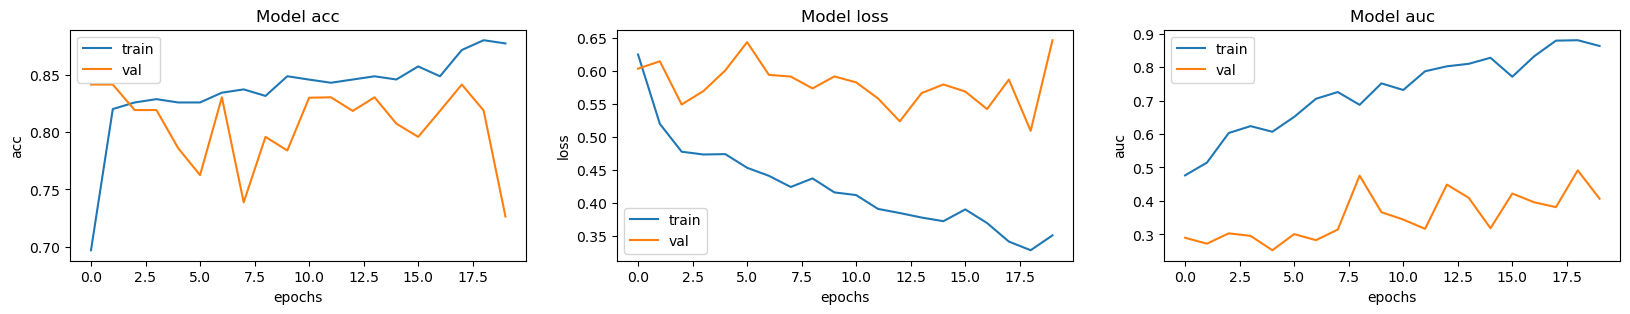

In [35]:
avg = {}
for metric in ["acc", "loss", 'auc']:
    avg[metric] = [sum(value) / 3 for value in zip(fold_history[0][metric], fold_history[1][metric], fold_history[2][metric])]
    avg['val_' + metric] = [sum(value) / 3 for value in zip(fold_history[0]['val_' + metric], fold_history[1]['val_' + metric], fold_history[2]['val_' + metric])]

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss", 'auc']):
    ax[i].plot(avg[metric])
    ax[i].plot(avg["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [31]:
max_auc_idx = np.argmax(avg['val_auc'])

print('acc:', avg['acc'][max_auc_idx])
print('loss:', avg['loss'][max_auc_idx])
print('auc:', avg['auc'][max_auc_idx])
print('val_acc:', avg['val_acc'][max_auc_idx])
print('val_loss:', avg['val_loss'][max_auc_idx])
print('val_auc:', avg['val_auc'][max_auc_idx])

acc: 0.9125000238418579
loss: 0.3476341664791107
auc: 0.4912932813167572
val_acc: 0.9166666666666666
val_loss: 0.34336499373118085
val_auc: 0.6276992162068685


In [1]:
t1a_val_acc

NameError: name 't1a_val_acc' is not defined

In [39]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train.to_numpy()))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val.to_numpy()))

batch_size = 5
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

In [40]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[ "acc", tf.keras.metrics.AUC(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives() ],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
)


Epoch 1/100
39/39 - 28s - loss: 0.6416 - acc: 0.6562 - auc: 0.6731 - true_negatives: 79.0000 - true_positives: 47.0000 - false_negatives: 24.0000 - false_positives: 42.0000 - val_loss: 1.6149 - val_acc: 0.4286 - val_auc: 0.5978 - val_true_negatives: 0.0000e+00 - val_true_positives: 21.0000 - val_false_negatives: 0.0000e+00 - val_false_positives: 28.0000
Epoch 2/100
39/39 - 4s - loss: 0.5620 - acc: 0.7240 - auc: 0.7641 - true_negatives: 99.0000 - true_positives: 40.0000 - false_negatives: 31.0000 - false_positives: 22.0000 - val_loss: 1.5354 - val_acc: 0.4286 - val_auc: 0.5884 - val_true_negatives: 0.0000e+00 - val_true_positives: 21.0000 - val_false_negatives: 0.0000e+00 - val_false_positives: 28.0000
Epoch 3/100
39/39 - 4s - loss: 0.5687 - acc: 0.7135 - auc: 0.7558 - true_negatives: 93.0000 - true_positives: 44.0000 - false_negatives: 27.0000 - false_positives: 28.0000 - val_loss: 0.8938 - val_acc: 0.4286 - val_auc: 0.6565 - val_true_negatives: 0.0000e+00 - val_true_positives: 21.0000

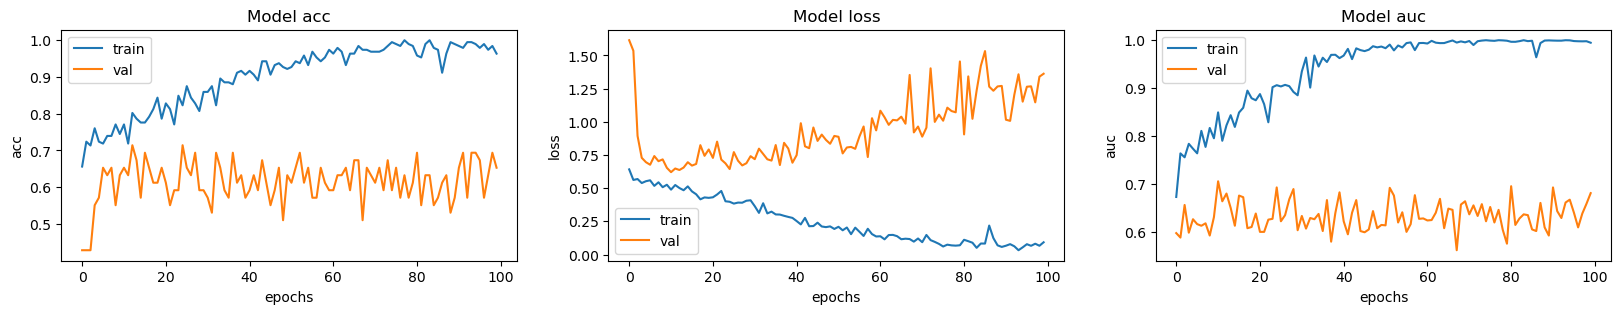

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss", 'auc']):
    # print(i, '. train:', model.history.history[metric])
    # print(i, '. val:', model.history.history["val_" + metric])
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [38]:
result = model.predict(t1a_val_data, batch_size=5)

result[result > 0.5] = 1
result[result < 0.5] = 0

accuracy_score(t1a_val_label['grade'], result)

In [43]:
model.history.history.keys()

dict_keys(['loss', 'acc', 'auc', 'true_negatives', 'true_positives', 'false_negatives', 'false_positives', 'val_loss', 'val_acc', 'val_auc', 'val_true_negatives', 'val_true_positives', 'val_false_negatives', 'val_false_positives'])

In [151]:
ct_data_2D = np.array(list(map(lambda x: resize_volume(x, 3, 128, 128), ct_data)))

In [249]:
ct_data_2D.shape

(240, 128, 128, 3)

In [175]:
x_train_2D, x_val_2D, y_train_2D, y_val_2D = train_test_split(ct_data_2D, label_grade['grade'], test_size = 0.2, random_state=42)

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train_2D.shape[0], x_val_2D.shape[0])
)

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train_2D, y_train_2D.to_numpy()))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val_2D, y_val_2D.to_numpy()))

batch_size = 5
# Augment the on the fly during training.
train_dataset_2D = (
    train_loader.shuffle(len(x_train_2D))
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset_2D = (
    validation_loader.shuffle(len(x_val_2D))
    .batch(batch_size)
    .prefetch(2)
)

Number of samples in train and validation are 192 and 48.


In [179]:
from tensorflow.keras.applications.resnet50 import ResNet50

conv_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'res5b_branch2a':
        set_trainable = True
        print('Got here')
    if set_trainable:
        layer.trainable = True
    else :
        layer.trainable = False
        

x = keras.layers.Flatten()(conv_base.output)
x = keras.layers.Dense(1000, activation='relu')(x)
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

resnet_model = keras.Model(inputs = conv_base.input, outputs = predictions)
resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_23[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [181]:
# Compile model.
resnet_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[ "acc", tf.keras.metrics.AUC(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives() ],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_resnet_image_classification.h5", save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)


# Train the model, doing validation at the end of each epoch
epochs = 100
resnet_model.fit(
    train_dataset_2D,
    validation_data=validation_dataset_2D,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)


Epoch 1/100
39/39 - 3s - loss: 0.1093 - acc: 0.9688 - auc_25: 0.9912 - true_negatives_19: 114.0000 - true_positives_18: 72.0000 - false_negatives_19: 3.0000 - false_positives_19: 3.0000 - val_loss: 4.2265 - val_acc: 0.6875 - val_auc_25: 0.6101 - val_true_negatives_19: 23.0000 - val_true_positives_18: 10.0000 - val_false_negatives_19: 7.0000 - val_false_positives_19: 8.0000
Epoch 2/100
39/39 - 1s - loss: 0.1123 - acc: 0.9688 - auc_25: 0.9917 - true_negatives_19: 114.0000 - true_positives_18: 72.0000 - false_negatives_19: 3.0000 - false_positives_19: 3.0000 - val_loss: 4.7453 - val_acc: 0.6875 - val_auc_25: 0.5712 - val_true_negatives_19: 30.0000 - val_true_positives_18: 3.0000 - val_false_negatives_19: 14.0000 - val_false_positives_19: 1.0000
Epoch 3/100
39/39 - 1s - loss: 0.4366 - acc: 0.9427 - auc_25: 0.9674 - true_negatives_19: 112.0000 - true_positives_18: 69.0000 - false_negatives_19: 6.0000 - false_positives_19: 5.0000 - val_loss: 3.9175 - val_acc: 0.7292 - val_auc_25: 0.6328 - va

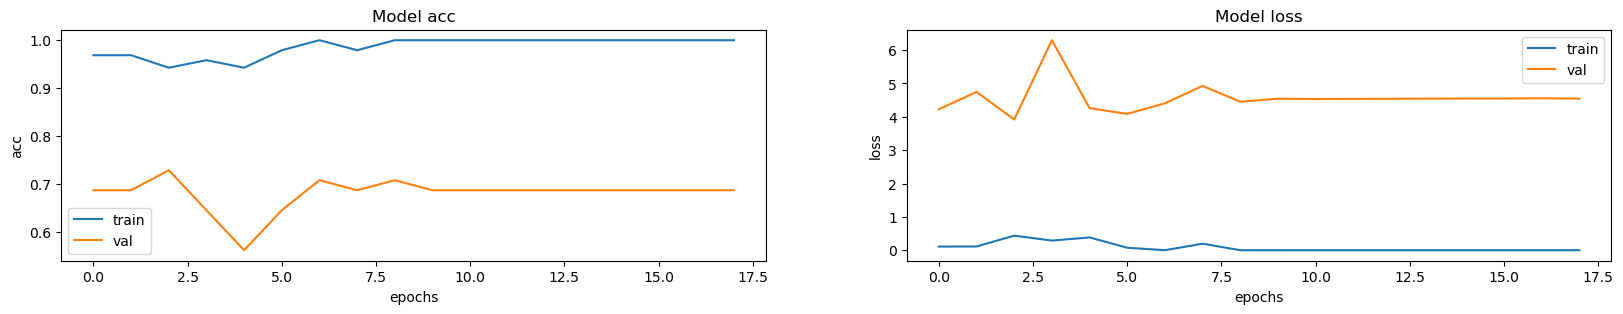

In [182]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss", "auc"]):
    # print(i, '. train:', model.history.history[metric])
    # print(i, '. val:', model.history.history["val_" + metric])
    ax[i].plot(resnet_model.history.history[metric])
    ax[i].plot(resnet_model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
